In [1]:
import os, sys
os.chdir("..")
sys.path.append("..")

from utils.support import pkl_load
from open_eyes_classificator.main import OpenEyesClassificator

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import log_loss

In [2]:
# see ./notebooks/inference_analysis/accuracy_threshold_selection.ipynb
accuracy_ths = 0.59
low_confidence = 0.7

pth = Path("../notebooks/inference_analysis/preview")

In [3]:
df = pkl_load("../output/crossval_split/crossval_dct.pkl")["hidden"]
cls = OpenEyesClassificator(device="gpu")

df["pred_proba"] = df["cew_img"].apply(lambda inpIm: cls.predict(inpIm))
df["pred"] = (df["pred_proba"] > accuracy_ths).astype(int)

print(f"Accuracy - {round((df['label'] == df['pred']).mean(), 4)}")
print(f"Log-loss - {round(log_loss(df['label'], df['pred_proba']), 4)}")
df.head(3)

Accuracy - 0.9775
Log-loss - 0.0691


,cew_img,original_img,label,pred_proba,pred
2,../data/dataset_B_Eye_Images/closedRightEyes/c...,None,0,0.082598,0
3,../data/dataset_B_Eye_Images/closedRightEyes/c...,None,0,0.073214,0
8,../data/dataset_B_Eye_Images/closedLeftEyes/cl...,None,0,0.000016,0


In [4]:
def preview(df, ncols, size, pth=None):
    nrows = int(len(df) / ncols) + (len(df) % ncols > 0)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            figsize=(ncols*size, nrows*size))
    fig.patch.set_facecolor('white')
    for ax in axs.flatten():
        ax.axis('off')
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        img = cv2.imread(str(row["cew_img"]), cv2.IMREAD_GRAYSCALE)
        ax.imshow(img, cmap=plt.get_cmap('gray'))
        ax.set_title(f"True-{row['label']} | Pred-{round(row['pred_proba'], 3)}")

    plt.tight_layout()
    if pth:
        plt.savefig(pth)
    plt.show()
    plt.close()

# False Negative

Total FN: 8


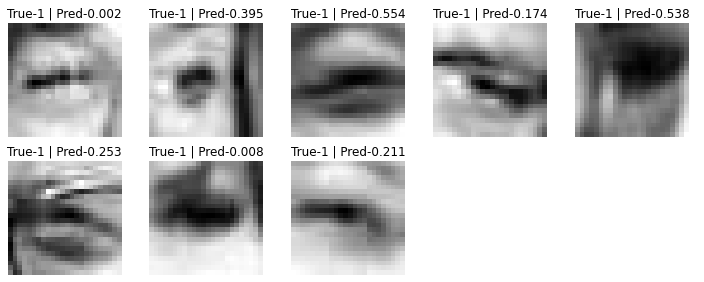

In [5]:
fn = df[
    (df["label"] != df["pred"]) &
    (df["label"] == 1)
]
print(f"Total FN: {fn.shape[0]}")
preview(fn, 5, 2, pth / "fn.png")

# False Positive

Total FP: 11


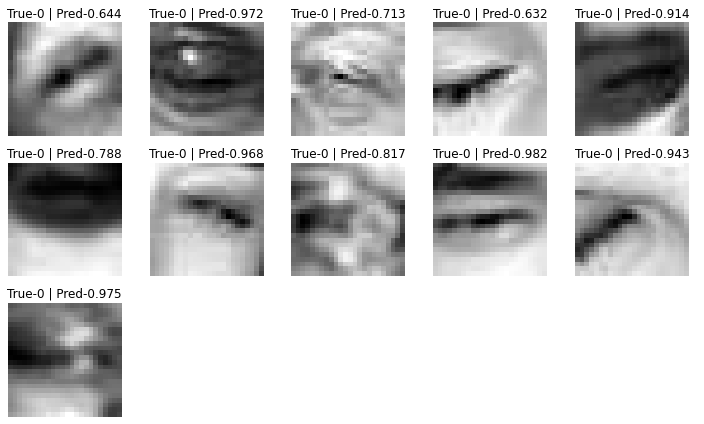

In [6]:
fp = df[
    (df["label"] != df["pred"]) &
    (df["label"] == 0)
]
print(f"Total FP: {fp.shape[0]}")
preview(fp, 5, 2, pth / "fp.png")

# True Positive with Low Confidence

In [7]:
tp = df[
    (df["pred"] == 1) &
    
    (df["pred"] == df["label"]) &
    (df["pred_proba"] < low_confidence)
]
print(f"Total TP (low conf.): {tp.shape[0]}")
if tp.shape[0] > 0:
    preview(tp, 5, 2, pth / "tp_low_conf.png")

Total TP (low conf.): 0


# True Negative with Low Confidence

Total TN (low conf.): 9


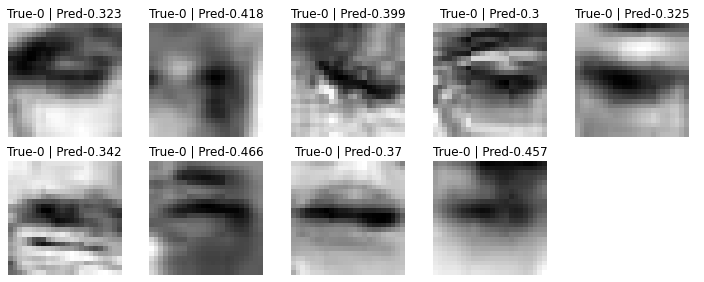

In [8]:
tn = df[
    (df["pred"] == 0) &
    
    (df["pred"] == df["label"]) &
    (df["pred_proba"] > (1 - low_confidence))
]
print(f"Total TN (low conf.): {tn.shape[0]}")
if tn.shape[0] > 0:
    preview(tn, 5, 2, pth / "tn_low_conf.png")